<br/>

$$ \huge{\underline{\textbf{ ANN and Correlated Data }}} $$

<br/>

This is a super quick post to demostrate what happens when we feed correlated data into an artificial neural network. This is specially relevant when doing **reinforcement learning**. As agent traverses environment, **subsequent states are highly correlated**, i.e. what agent sees at time step t=100 is usually very similar to t=101, t=102 and so on.

We will also show a sneek peek on how **memory reply** fixes the issue.

Content:
* [Mini ANN](#Mini-ANN)
* [Test ANN with correlated data](Test-ANN-with-correlated-data)
* [Add pseudo memory reply](Add-pseudo-memory-reply)

# Mini ANN

In [98]:
import time
import numpy as np
import matplotlib.pyplot as plt

Minimal implementation of ANN using only numpy. Nothing new here, you can skip this section.
* two layers only
  * sigmoid hidden layer
  * linear (no activation) output layer

In [2]:
class ANNFuncApprox():
    """Minimal ANN implementation
    
    Layers:
        * 1x hidden sigmoid layer
        * 1x linear output layer
    """
    def __init__(self, learn_rate, x_min, x_max, nb_in, nb_hid, nb_out):
        """
        Params:
            learn_rate - learn rate for backprop
            x_min      - minimum values for inputs - for scaling
            x_max      - maximum values for inputs - for scaling
            nb_in      - number of inputs
            nb_hid     - number of hidden neurons
            nb_outt    - number of outputs
        """
        self._lr = learn_rate
        self._x_min = x_min
        self._x_max = x_max
        
        self._Wh = np.random.normal(loc=0, scale=1/nb_in**-.5, size=[nb_in, nb_hid])   # Xavier
        self._bh = np.zeros(shape=[1, nb_hid])
        self._Wo = np.random.normal(loc=0, scale=1/nb_hid**-.5, size=[nb_hid, nb_out])
        self._bo = np.zeros(shape=[1, nb_out])
        
    def eval(self, x):
        """Forward pass on neural network
        
        Params:
            x - input, either scalar or 2d np.ndarray with dims: [batch_size, num_inputs]
        """
        if np.isscalar(x):   x = np.array([[x]])             # needed so @ operator works ok
        assert x.ndim == 2                                   # tested for 2d numpy arrays only
        
        x = (x - self._x_min) / (self._x_max - self._x_min)  # scale input to range [0..1]
        
        z_hid = x @ self._Wh + self._bh                      # input to hidden layer
        h_hid = self.sigmoid(z_hid)                          # output from hidden layer
        z_out = h_hid @ self._Wo + self._bo                  # input to output layer
        y_hat = z_out                                        # output (linear activation)
        
        return y_hat

        
    def train(self, x, y):
        """Perform batch update using backprop
        
        Params:
            x - input, either scalar or 2d np.ndarray with dims: [batch_size, num_inputs]
            y - target, either scalar or 2d np.ndarray with dims: [batch_size, num_outputs]
        """
        if np.isscalar(x):   x = np.array([[x]])             # needed so @ operator works ok
        if np.isscalar(y):   y = np.array([[y]])
        
        x = (x - self._x_min) / (self._x_max - self._x_min)  # scale to range [0..1]
        
        # Forward pass
        z_hid = x @ self._Wh + self._bh                      # input to hidden layer
        h_hid = self.sigmoid(z_hid)                          # output from hidden layer
        z_out = h_hid @ self._Wo + self._bo                  # input to output layer
        y_hat = z_out                                        # output (linear activation)
        
        # Backward pass
        ro_o = -1 * (y - y_hat)                              # error term output layer (linear)
        dWo = h_hid.T @ ro_o                      / len(x)   # delta weights output
        dbo = np.sum(ro_o, axis=0, keepdims=True) / len(x)   # delta biases output
        ro_h = ro_o @ self._Wo.T * self.sigmoid_deriv(z_hid) # error term hidden layer
        dWh = x.T @ ro_h                          / len(x)   # delta weights hidden
        dbh = np.sum(ro_h, axis=0, keepdims=True) / len(x)   # delta biases hidden
        
        # Update weights
        self._Wh += -self._lr * dWh
        self._bh += -self._lr * dbh
        self._Wo += -self._lr * dWo
        self._bo += -self._lr * dbo
        
        return dWh, dbh, dWo, dbo       # so we can do numerical gradient check
            
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def sigmoid_deriv(self, x):
        return ANNFuncApprox.sigmoid(x) * (1 - ANNFuncApprox.sigmoid(x))

# Test ANN with correlated data

Let's create some data to work with - this is going to be the most boring data set ever
* **x** is going to be input, range -100 ... 100, step 0.1
* **y** is target to learn - just re-scaled x

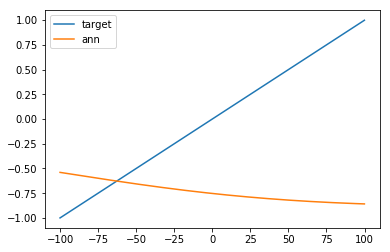

In [91]:
x = np.arange(-100, 100, 0.1)
x_T = np.array(x, ndmin=2).T       # x_T as vertical vector, required by ANN batch mode
y = x / 100                        # learn stright line, should be easy

And let's create a neural network
* one input neuron - x is scalar
* 3 hidden neurons - we are learning to approximate stright line so this should be plenty enough
* one output neuron - y is also scalar

Note that I have picked hyper-parameters to exaggerate the effect for educational purposes.

In [93]:
ann = ANNFuncApprox(learn_rate=0.1, x_min=-100, x_max=100, nb_in=1, nb_hid=3, nb_out=1)

Plot untrained neural net

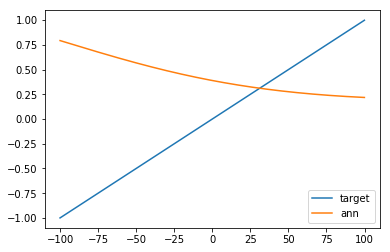

In [94]:
plt.plot(x, y, label='target')
plt.plot(x, ann.eval(x_T), label='ann')
plt.legend();

Let's feed correlated data into the neural net. We will traverse data set from left (-100) to right (100) one data point at a time and feed that single data point into neural net. This is more or less what would happen if we were training RL agent using e.g. TD learning.

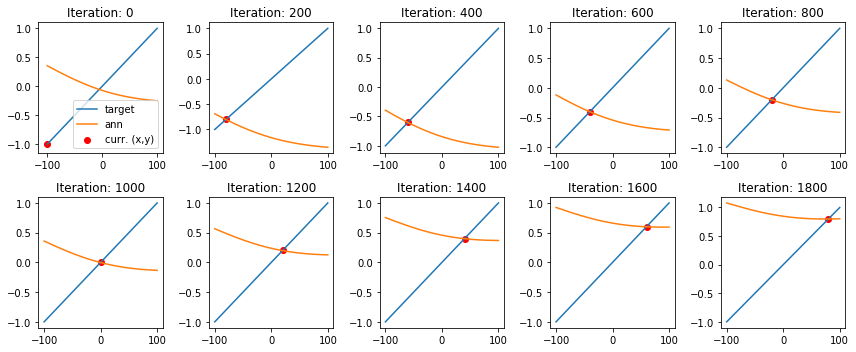

In [95]:
fig = plt.figure(figsize=[12,5])

for i in range(len(x)):       # move from left to right
    ann.train(x[i], y[i])     # feed one sample at a time
    
    if i % 200 == 0:
        ax = fig.add_subplot(2,5,i//200+1)
        ax.plot(x, y, label='target')
        ax.plot(x, ann.eval(x_T), label='ann')
        ax.scatter(x[i], y[i], color='red', label='curr. (x,y)')
        ax.set_title('Iteration: '+str(i))
        if i == 0:
            ax.legend();

plt.tight_layout()
plt.show()

Looding at the plots:
* iteration 0 - untrained neural net
* iteration 200 - by this point neural net correctly learned red data point
* iteration 400 - but as we keep moving right, neural net "cares" only about current data point!
* iteratios 600 oward - this is clearly not working

# Add pseudo memory reply

Let's try this again, reset the neural net

In [96]:
ann = ANNFuncApprox(learn_rate=0.1, x_min=-100, x_max=100, nb_in=1, nb_hid=3, nb_out=1)

As before agent will traverse data set from left to right, but this time we train ANN with random point from data points seen so far.

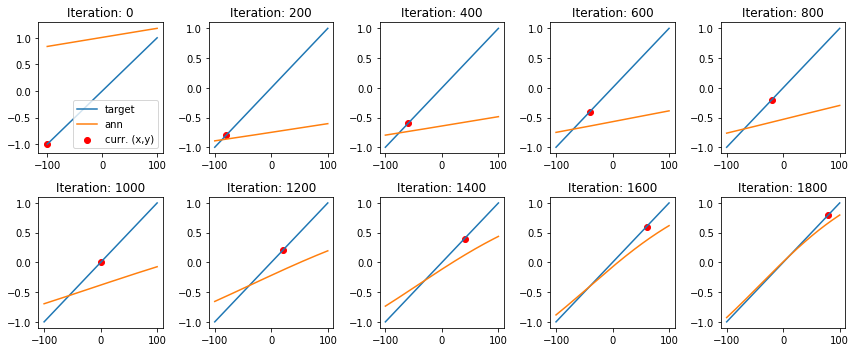

In [97]:
fig = plt.figure(figsize=[12,5])

for i in range(len(x)): 
    
    k = np.random.randint(0, i+1)   # <- THIS CHANGED: pick random data point from the past
    ann.train(x[k], y[k])
    
    if i % 200 == 0:
        ax = fig.add_subplot(2,5,i//200+1)
        ax.plot(x, y, label='target')
        ax.plot(x, ann.eval(x_T), label='ann')
        ax.scatter(x[i], y[i], color='red', label='curr. (x,y)')
        ax.set_title('Iteration: '+str(i))
        if i == 0:
            ax.legend();

plt.tight_layout()
plt.show()

As you can see, even though we used exactly the same number of points to train neural net, now it clearly doesn't forget the past and tries to fit the whole data set.